# Simple Iceberg Drift Model

An implementation of the model described in Turnball (2015).

### Equation of Motion

\begin{align}
M \frac{d \vec{V}}{dt} = \vec{F_a} + \vec{F_w} + \vec{F_c} + \vec{F_{wp}}
\end{align}

#### Air drag

\begin{align}
\vec{F_a} = (0.5 \rho_a C_a A_s + \rho_a C_{da} A_t ) \left| \vec{V_w} - \vec{V} \right| (\vec{V_w} - \vec{V})
\end{align}

#### Water drag

\begin{align}
\vec{F_w} = 
\end{align}

#### Coriolis

\begin{align}
\vec{F_c} &= 2 M \Omega \sin\phi \vec{k} \times \vec{V} \\
\end{align}

That is,

\begin{align}
\vec{F_c} / M &= (+f v, -fu, 0)
\end{align}

where $ f = 2\Omega \sin\phi $ is the Coriolis parameter.

#### Water pressure gradient

\begin{align}
\vec{F_{wp}} = 
\end{align}

### Iceberg shapes

The shape
* Tabular
* Non-Tabular
* Domed
* Pinnacle
* Wedge
* Drydock
* Blocky

is used to modify the parametrization for the external forces.

In [57]:
M_tons = 4.1e5 # metric tons
M = M_tons * 1000

### Applied forces

In [214]:
def Fa(vx, vy):
    """
    Calculate the air drag
    """
    vwind_x = 20.0 # nominal value
    vwind_y = 0
    
    ρa = 1.225 # kg/m^3
    Ca = 0.1
    As = 72 * 22 # (maximum width (m) * sail height (m))
    Fa_x = (0.5 * ρa * Ca * As) * abs(vwind_x - vx) * (vwind_x - vx)
    Fa_y = (0.5 * ρa * Ca * As) * abs(vwind_y - vy) * (vwind_y - vy)
    
    return Fa_x, Fa_y

In [ ]:
def Fw(vx, vy):
    """
    Calculate the water drag
    """
    return 0,0

In [200]:
def Fc(vx, vy):
    """
    Calculate the Coriolis force
    """
    Ω = 7.2921e-5 # rotation rate of earth in rad/s
    ϕ = np.deg2rad(50) # start with a nominal value of 50 degrees N
    
    f = 2*Ω*np.sin(ϕ) # calculate the Coriolis parameter
    
    Fc_x = + f * vy * M
    Fc_y = - f * vx * M
    
    return Fc_x, Fc_y

In [ ]:
def Fwp(vx, vy):
    """
    Calculate the water pressure gradient
    """
    return 0,0

In [275]:
def calc_acceleration(vx, vy):
    """
    """
    
    Fa_x, Fa_y = Fa(vx, vy)
    Fc_x, Fc_y = Fc(vx, vy)
            
    ax = (Fa_x + Fc_x) / M
    ay = (Fa_y + Fc_y) / M
    
    return ax, ay

In [276]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

### Numerical scheme

In [346]:
def solve(dt=1.0):
    """
    Solve the equations of motion with
        dt time step in seconds
    """
    tmax_hours = 72
    tmax = tmax_hours*60*60 # hours to seconds
    
    # total number of timesteps
    N = round(tmax/dt)

    # allocate memory for arrays
    x = np.zeros(N)
    y = np.zeros(N)
    vx = np.zeros(N)
    vy = np.zeros(N)
    ax = np.zeros(N)
    ay = np.zeros(N)
    t = np.zeros(N)

    # initial values
    x[0] = 0
    y[0] = 0
    vx[0] = 0
    vy[0] = 0
    ax[0], ay[0] = calc_acceleration(vx[0], vy[0])
    t[0] = 0

    # integrate numerically
    for i in range(N-1):
        if i < 1:
            # explicit Euler forward scheme
            vx[i+1] = vx[i] + dt*ax[i]
            vy[i+1] = vy[i] + dt*ay[i]
        
            ax[i+1], ay[i+1] = calc_acceleration(vx[i+1], vy[i+1])
        elif i < 3:
            # second order Adams Bashforth
            vx[i+1] = vx[i] + dt*(1.5*ax[i]-0.5*ax[i-1])
            vy[i+1] = vy[i] + dt*(1.5*ay[i]-0.5*ay[i-1])
            
            ax[i+1], ay[i+1] = calc_acceleration(vx[i+1], vy[i+1])
        else:
            # fourth order Adams Bashforth, predictor-corrector
            vx[i+1] = vx[i] + dt/24*(55*ax[i]-59*ax[i-1]+37*ax[i-2]-9*ax[i-3])
            vy[i+1] = vy[i] + dt/24*(55*ay[i]-59*ay[i-1]+37*ay[i-2]-9*ay[i-3])    
            
            ax[i+1], ay[i+1] = calc_acceleration(vx[i+1], vy[i+1])
            
            vx[i+1] = vx[i] + dt/24*(9*ax[i+1]+19*ax[i]-5*ax[i-1]+ax[i-2])
            vy[i+1] = vy[i] + dt/24*(9*ay[i+1]+19*ay[i]-5*ay[i-1]+ay[i-2])
            
            ax[i+1], ay[i+1] = calc_acceleration(vx[i+1], vy[i+1])
            
        x[i+1] = x[i] + dt*vx[i+1]
        y[i+1] = y[i] + dt*vy[i+1]
  
        t[i+1] = t[i] + dt
        
        #print("{:8.1f} {:12.1f} {:12.1f} {:12.1f}".format(t[i+1], x[i+1], vx[i+1], ax[i+1]))
    
    return x, y, t

#### Plotting routine

In [347]:
def plot(x, y, label=''):
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.plot(x, y, label=label)

#### Driver

<IPython.core.display.Javascript object>


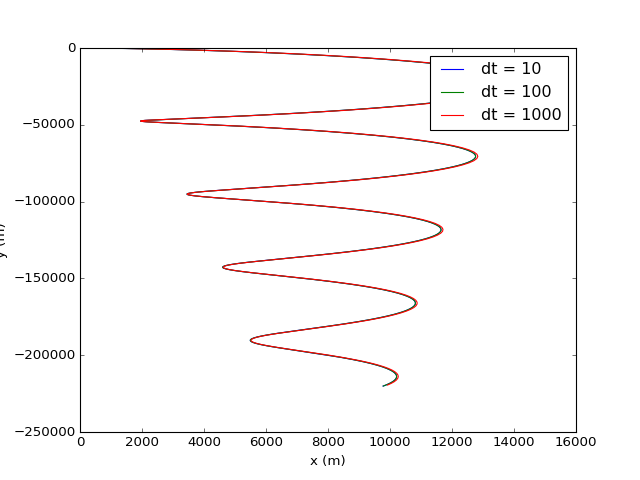

In [351]:

fig, axes = plt.subplots()

for dt in [10, 100, 1000]:
    x, y, t = solve(dt=dt)
    plot(x,y, label='dt = {}'.format(dt))
#x, y, t = solve(check=False)
#plot(x,y, label='do not acceleration again')
plt.legend()
#plt.axis('equal')